In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electric-power-consumption/powerconsumption.csv


In [2]:
data_path = '/kaggle/input/electric-power-consumption/powerconsumption.csv'  # Update with the actual file path
df = pd.read_csv(data_path)

print(df.columns)

Index(['Datetime', 'Temperature', 'Humidity', 'WindSpeed',
       'GeneralDiffuseFlows', 'DiffuseFlows', 'PowerConsumption_Zone1',
       'PowerConsumption_Zone2', 'PowerConsumption_Zone3'],
      dtype='object')


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load the dataset
data_path = '/kaggle/input/electric-power-consumption/powerconsumption.csv'  # Update with the actual file path
df = pd.read_csv(data_path)

# Parse Date Time and drop the column for simplicity
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.drop(columns=['Datetime'], inplace=True)

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Convert to DataFrame for easier handling
df_scaled = pd.DataFrame(scaled_data, columns=df.columns)

# Define target column (e.g., Zone 1 Power Consumption)
TARGET_COLUMN = 'PowerConsumption_Zone1'
WINDOW_SIZE = 30

# Create sequences
def create_sequences(data, target_col, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, :-1])  # All columns except the target
        y.append(data[i + window_size, target_col])
    return np.array(X), np.array(y)

X, y = create_sequences(df_scaled.values, df.columns.get_loc(TARGET_COLUMN), WINDOW_SIZE)

# Train-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.1, random_state=2024)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=2024)

# Convert to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [4]:
import torch.nn as nn

class CNNTransformer(nn.Module):
    def __init__(self, feature_dim, d_model, num_heads, num_layers, dropout=0.1, cnn_kernel_size=3, cnn_out_channels=64):
        super(CNNTransformer, self).__init__()
        
        # CNN for feature extraction
        self.cnn = nn.Conv1d(in_channels=feature_dim, out_channels=cnn_out_channels, kernel_size=cnn_kernel_size, padding=cnn_kernel_size // 2)
        self.cnn_projection = nn.Linear(cnn_out_channels, d_model)
        
        # Positional encoding
        self.positional_encoding = nn.Parameter(torch.zeros(1, WINDOW_SIZE, d_model))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output layer
        self.fc_out = nn.Linear(d_model, 1)
    
    def forward(self, src):
        src = src.permute(0, 2, 1)  # (batch_size, feature_dim, window_size)
        cnn_out = self.cnn(src)  # (batch_size, cnn_out_channels, window_size)
        cnn_out = cnn_out.permute(0, 2, 1)  # (batch_size, window_size, cnn_out_channels)
        cnn_out = self.cnn_projection(cnn_out)  # (batch_size, window_size, d_model)
        
        src = cnn_out + self.positional_encoding  # Add positional encoding
        out = self.transformer(src)  # Transformer output
        out = out.mean(dim=1)  # Mean pooling
        return self.fc_out(out).squeeze(-1)


In [5]:
# Hyperparameters
FEATURE_DIM = X_train.shape[2]
D_MODEL = 128
NUM_HEADS = 4
NUM_LAYERS = 3
DROPOUT = 0.1
EPOCHS = 3

# Initialize model
model = CNNTransformer(
    feature_dim=FEATURE_DIM,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define optimizer and loss function
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    
    val_loss /= len(val_loader.dataset)
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/3, Train Loss: 0.1834, Val Loss: 0.0251
Epoch 2/3, Train Loss: 0.0209, Val Loss: 0.0297
Epoch 3/3, Train Loss: 0.0128, Val Loss: 0.0087


In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluate model on test set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        predictions = model(X_batch)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Compute metrics
y_true = np.array(y_true)
y_pred = np.array(y_pred)

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")


MAE: 0.0735, MSE: 0.0102, RMSE: 0.1008, R²: 0.9900


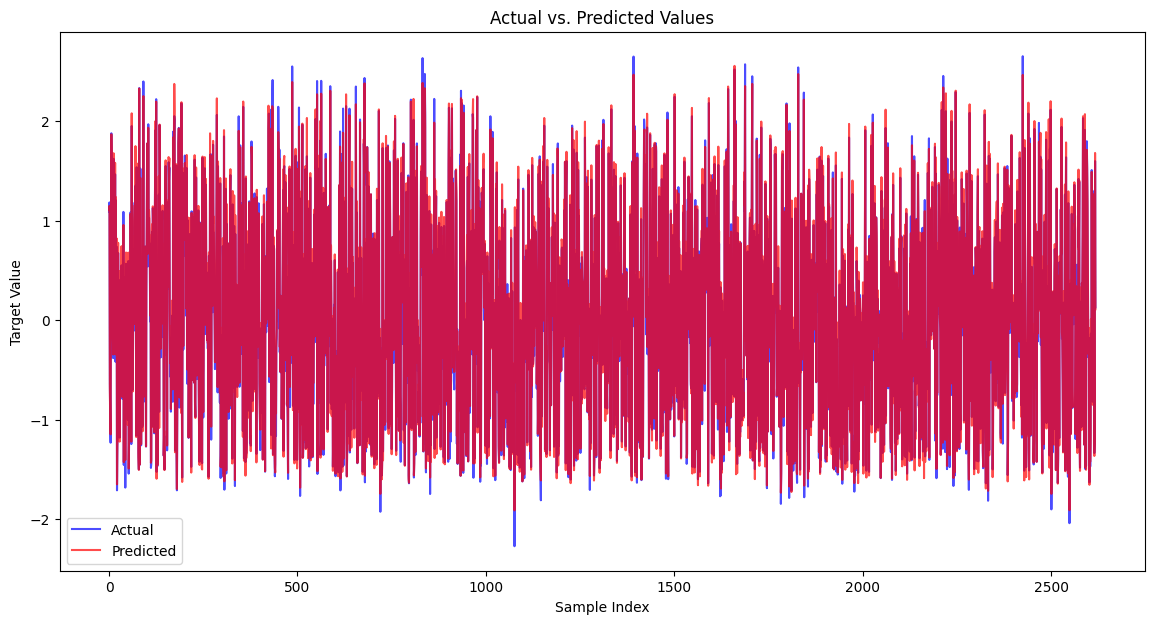

In [7]:
import matplotlib.pyplot as plt

# Generate predictions on the validation set
model.eval()
predictions = []
actual_values = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        
        predictions.append(y_pred.cpu().numpy())
        actual_values.append(y_batch.cpu().numpy())

# Flatten the lists of predictions and actual values
predictions = np.concatenate(predictions, axis=0)
actual_values = np.concatenate(actual_values, axis=0)

# Plot actual vs. predicted values
plt.figure(figsize=(14, 7))
plt.plot(actual_values, label='Actual', color='blue', alpha=0.7)
plt.plot(predictions, label='Predicted', color='red', alpha=0.7)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()


In [8]:
residuals = y_true - y_pred

plt.figure(figsize=(14, 7))
plt.scatter(range(len(residuals)), residuals, color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals of Predictions on Test Data')
plt.xlabel('Sample Index')
plt.ylabel('Residual')
plt.show()


TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'

In [ ]:
plt.figure(figsize=(14, 7))
plt.hist(y_pred, bins=30, alpha=0.7, label='Predicted Values')
plt.hist(y_true, bins=30, alpha=0.7, label='Actual Values')
plt.title('Histogram of Actual vs. Predicted Values')
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(y_true, y_pred)
print(f"R² Score: {r2:.4f}")


In [ ]:
from statsmodels.tsa.seasonal import STL

# Decompose a single time series (e.g., Zone 1 Power Consumption)
def decompose_time_series(series, period):
    stl = STL(series, period=period)
    result = stl.fit()
    return result.trend, result.seasonal, result.resid

# Example: Decompose Zone 1 Power Consumption
trend, seasonal, resid = decompose_time_series(df_final['PowerConsumption_Zone1'], period=144)  # Period for 1 day


In [ ]:
# Train the hybrid CNN-Transformer model
# Use the model to predict future values (e.g., for Zone 1 Power Consumption)
predictions = model(encoder_input, decoder_input)  # Predictions for the entire series

# Decompose the predictions into trend, seasonality, and residuals
predicted_trend, predicted_seasonal, predicted_residuals = decompose_time_series(predictions.detach().cpu().numpy(), period=144)


In [ ]:
# Compute residuals (actual - predicted)
actual_residuals = resid
predicted_residuals = df_final['PowerConsumption_Zone1'] - predictions.detach().cpu().numpy()

# Define thresholds for anomalies
threshold = 2 * predicted_residuals.std()  # Example: 2 standard deviations

# Detect anomalies
trend_anomalies = abs(trend - predicted_trend) > threshold
seasonal_anomalies = abs(seasonal - predicted_seasonal) > threshold
residual_anomalies = abs(actual_residuals) > threshold


In [ ]:
# Aggregate anomalies
df_final['Trend Anomaly'] = trend_anomalies
df_final['Seasonal Anomaly'] = seasonal_anomalies
df_final['Residual Anomaly'] = residual_anomalies
df_final['Overall Anomaly'] = trend_anomalies | seasonal_anomalies | residual_anomalies


In [ ]:
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are available as numpy arrays or tensors
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red', alpha=0.7)
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Convert the predictions to a NumPy array for visualization
y_test_actual = y_test_tensor.numpy()
y_pred_actual = y_pred.flatten()

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual', color='blue')
plt.plot(y_pred_actual, label='Predicted', color='red', alpha=0.7)
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()


# Model from scratch

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn#neural network
import torch.nn.functional as F#
import torch.optim as optim#
import gc#
import warnings#
warnings.filterwarnings('ignore')#filterwarnings()。

import random
def seed_everything(seed):
    torch.backends.cudnn.deterministic = True#
    torch.backends.cudnn.benchmark = False#，
    torch.manual_seed(seed)#
    np.random.seed(seed)#
    random.seed(seed)#
seed_everything(seed=2024)

In [ ]:
import matplotlib.pyplot as plt

# Get unique IDs
unique_ids = df_final['unique_id'].unique()

# Split unique IDs into two groups
group1 = unique_ids[:5]  # First 5
group2 = unique_ids[5:]  # Rest


plt.figure(figsize=(12, 6))
for i in range(len(group1)):
    crop_data = df_final[df_final['unique_id'] == i]
    plt.plot(crop_data['ds'], crop_data['y'], label=f'Price of {cities[i]}')
    
plt.title('Prices first 5 cities', fontsize=16)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Price (y)', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
for i in range(len(group2)):
    crop_data = df_final[df_final['unique_id'] == i+5]
    plt.plot(crop_data['ds'], crop_data['y'], label=f'Price of {cities[i+5]}')

plt.title('Prices last 5 cities', fontsize=16)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Price (y)', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Check the unique IDs in your dataset
unique_ids = df_final['unique_id'].unique()

# Create a DataFrame to hold the results
missing_data = []

# Iterate over each date
for date in df_final['ds'].unique():
    # Filter the DataFrame for the current date
    daily_data = df_final[df_final['ds'] == date]
    
    # Check if all 10 unique IDs are present
    missing_ids = set(unique_ids) - set(daily_data['unique_id'])
    if missing_ids:
        missing_data.append({
            'date': date,
            'missing_ids': list(missing_ids),
            'missing_columns': 'All'
        })
    else:
        # Check for missing values in 'y', 'USD', and 'petrol'
        for unique_id in unique_ids:
            row = daily_data[daily_data['unique_id'] == unique_id]
            if row[['y', 'USD', 'petrol']].isnull().values.any():
                missing_data.append({
                    'date': date,
                    'missing_ids': unique_id,
                    'missing_columns': row[['y', 'USD', 'petrol']].isnull().any(axis=0).index[row.isnull().values[0]].tolist()
                })

# Convert the results into a DataFrame for better visualization
missing_data_df = pd.DataFrame(missing_data)

# Display the missing data
if missing_data_df.empty:
    print("No missing values. All dates have valid entries for all unique IDs.")
else:
    print(missing_data_df)

In [ ]:
# Get the unique dates from the DataFrame index
unique_dates = df_final['ds'].unique()

# Determine the split index
split_index = int(len(unique_dates) -60)

# Split the dates into training and test sets
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

# Create the training and test DataFrames
train = df_final[df_final['ds'].isin(train_dates)]
test = df_final[df_final['ds'].isin(test_dates)]

# Check the results
print(f"Training set contains {len(train)} rows from {len(train_dates)} unique dates.")
print(f"Test set contains {len(test)} rows from {len(test_dates)} unique dates.")

In [ ]:
print(df_final.columns)

In [ ]:
feats=['y','USD','petrol','temp', 'precip','conditions']
#Batch, Target, Prediction Size Number of Features
B,T,S,N=128,180,60,len(feats)
device ='cuda' if  torch.cuda.is_available() else 'cpu'
class Embedding(nn.Module):
    def __init__(self,input_dim=128,embed_dim=256,dropout=0.1,device=device):
        super(Embedding,self).__init__()
        self.input_dim=input_dim
        self.embed_dim=embed_dim
        self.device=device
        self.head=nn.Sequential(
             nn.Linear(self.input_dim,self.embed_dim), 
        ).to(self.device)
        self.dropout=nn.Dropout(dropout)
        
    def forward(self,x):
        return self.dropout(self.head(x).to(self.device))
    
#Attention
class MultiHeadSelfAttention(nn.Module):
    #定义初始化函数,dim_in是embedding的维度，d_model是输出的维度
    def __init__(self,dim_in=512,d_model=512,num_heads=4,device=device):

        super(MultiHeadSelfAttention,self).__init__()
        self.padidx=2#中英文padding在字典里的下标
        self.dim_in,self.d_model,self.num_heads=dim_in,d_model,num_heads
        self.device=device
        
        #向量的维度必须被头的个数整除,否则会抛出异常.
        assert d_model %num_heads==0,"d_model must be multiple of num_heads"
        
        #定义线性变换矩阵
        self.linear_q=nn.Linear(dim_in,d_model).to(self.device)
        self.linear_k=nn.Linear(dim_in,d_model).to(self.device)
        self.linear_v=nn.Linear(dim_in,d_model).to(self.device)
        self.scale=1/np.sqrt(d_model//num_heads)
        #最后的线性层
        self.fc=nn.Linear(d_model,d_model).to(self.device)
        
    def forward(self,x):#x是input,x_copy是每个位置在字典中(中英文)的idx,为了去除padding项的影响.
        batch,n,dim_in=x.shape#(batch_size,max_len,embedding)
        
        assert dim_in==self.dim_in#检查一下输入的embedding维度是否正确
        
        nh=self.num_heads#几个头
        
        dk=self.d_model//nh
        #对x进行线性映射变成(batch_size,max_len,d_model) -> (batch_size,num_heads,max_len,d_model//num_heads)
        q=self.linear_q(x).reshape(batch,n,nh,dk).transpose(1,2)
        k=self.linear_k(x).reshape(batch,n,nh,dk).transpose(1,2)
        v=self.linear_v(x).reshape(batch,n,nh,dk).transpose(1,2)
        
        #q:(batch_size,num_heads,max_len,d_model//num_heads)
        #k.transpose(2,3):(batch_size,num_heads,d_model//num_heads,max_len)
        #dist:(batch_size,num_heads,max_len,max_len) (每个词和每个词的注意力)
        dist=torch.matmul(q,k.transpose(2,3))*self.scale
        
        #softmax  (batch_size,num_heads,max_len,max_len)
        dist=torch.softmax(dist,dim=-1)
        
        #v:(batch_size,num_heads,max_len,d_model//num_heads)
        #att:(batch_size,num_heads,max_len,d_model//num_heads)
        att=torch.matmul(dist,v)
        
        #(batch_size,max_len,num_heads,d_model//num_heads)->(batch_size,max_len,d_model)
        att=att.transpose(1,2).reshape(batch,n,self.d_model)
        
        #output:(batch_size,max_len,d_model)
        output=self.fc(att)
        
        return output
    
#前馈神经网络,捕获复杂的非线性关系.
class FeedForward(nn.Module):
    def __init__(self, dim=256, hidden_dim=256, dropout=0.1,device='cpu'):
        super().__init__()
        self.device=device
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim), 
            nn.Dropout(dropout)
        ).to(self.device)
    #将x传入神经网络中得到输出
    def forward(self, x):
        return self.net(x)
    
class iTransformer(nn.Module):
    def __init__(self,embed_dim=128,L=1,dropout=0.1,device=device):
        super(iTransformer,self).__init__()
        self.embed_dim=embed_dim#对时间维度映射的维度
        self.L=L#有几层att+feed
        self.dropout=dropout
        self.device=device
        self.encodeembedding=Embedding(input_dim=T,embed_dim=self.embed_dim,dropout=self.dropout,device=self.device)
        self.decodeembedding=Embedding(input_dim=self.embed_dim,embed_dim=S,dropout=0,device=self.device)
        
        self.att=[MultiHeadSelfAttention(dim_in=self.embed_dim,d_model=self.embed_dim,num_heads=4,device=self.device)for i in range(self.L)]
        self.feed=[FeedForward(dim=self.embed_dim,hidden_dim=self.embed_dim,dropout=self.dropout,device=self.device) for i in range(self.L)]
        self.laynorm=[nn.LayerNorm(self.embed_dim).to(self.device) for i in range(2*self.L)]
        self.Dropout=nn.Dropout(self.dropout)
        
    def forward(self,x):#(Batch_size,Time,N_features)
        x=x.to(self.device)
        #对第一个维度求均值,保留这个维度同时不参与计算图
        #(Batch_size,Time,N_features)->(Batch_size,1,N_features)
        means = x.mean(1, keepdim=True).detach().to(self.device)
        #对第一个维度计算标准差,保留维度,使用有偏估计(分母为n而不是n-1),加上1e-15防止分母为0
        stdev = torch.sqrt(torch.var(x, dim=1, keepdim=True, unbiased=False) + 1e-15).to(self.device)
        x = (x - means)/stdev

        x=torch.transpose(x,1,2).to(self.device)#(Batch_size,N_features,T)
        #MLP
        x=self.encodeembedding(x)#(Batch_size,N_features,embed_dim) 
        for i in range(self.L):
            x=x+self.Dropout(self.att[i](x))
            x=self.laynorm[2*i](x)
            x=x+self.feed[i](x)
            x=self.laynorm[2*i+1](x)
        #MLP
        x=self.decodeembedding(x).to(self.device)#(Batch_size,N_features,T)
        x=torch.transpose(x,1,2)#(Batch_size,N_features,T)
        x = x * (stdev.repeat(1, S, 1))
        x = x + (means.repeat(1, S, 1)).to(self.device)
        return x

class Model(nn.Module):
    def __init__(self,embed_dim=64,L=1,dropout=0.1,device='cpu'):
        super(Model,self).__init__()
        self.embed_dim=embed_dim#对时间维度映射的维度
        self.L=L#有几层att+feed
        self.dropout=dropout
        self.device=device
        self.iTransformer1=iTransformer(self.embed_dim,self.L,self.dropout,self.device)
        self.iTransformer2=iTransformer(self.embed_dim,self.L,self.dropout,self.device)
    def forward(self,x):#(Batch_size,Time,N_features)
        return (self.iTransformer1(x)+self.iTransformer2(x))/2

In [ ]:
submission=test[['y']].copy()
gt = test[['y']].copy()
print(test.head())
submission['y']=0
def loss_fn(y_true,y_pred):#torch.tensor
    y_pred=torch.clip(y_pred,0,1e20)
    return torch.mean((torch.log1p(y_true)-torch.log1p(y_pred))**2)
#这里使用官方的评估指标
def metric(y_true,y_pred):#np.array
    y_true=y_true.reshape(-1,y_true.shape[-1])
    y_pred=y_pred.reshape(-1,y_pred.shape[-1])
    return np.sqrt(np.mean((np.log1p(y_true)-np.log1p(y_pred))**2))
def R2(y_true,y_pred):
    return 1-np.mean((y_true-y_pred)**2)/np.mean((y_true-np.mean(y_true))**2)
cities = cities.tolist()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
print(f"device:{device}")

for i in range(len(cities)):
    print(f"started training for {cities[i]}")
    tmp_train=train[(train['unique_id']==i)]
    tmp_test=test[(test['unique_id']==i)]
    data=tmp_train[feats].values
    X,y=[],[]
    for k in range(len(data)-T-S):
        X.append(data[k:k+T])
        y.append(data[k+T:k+T+S])
    split=int(len(X)*0.8)
    #train_X,valid_X,train_y,valid_y=np.array(X[:split]),np.array(X[split:]),np.array(y)[:split,:,0:1],np.array(y)[split:,:,0:1]
    
    #full_data no valid 
    train_X,valid_X,train_y,valid_y=np.array(X),np.array(X[split:]),np.array(y)[:,:,0:1],np.array(y)[split:,:,0:1]
    
    #print(f"train_X.shape:{train_X.shape},train_y.shape:{train_y.shape},valid_X.shape:{valid_X.shape}")
    #模型设置
    model=Model(embed_dim=144,L=6,dropout=0.1,device=device)
    num_epochs=300
    batch_size=32
    #优化器设置
    optimizer=optim.AdamW(model.parameters(),lr=0.00003,betas=(0.5,0.999))
    epoch = 0
    best_val_loss = float('inf')
    count = 0
    while (epoch < num_epochs)and (count < 7):
        #模型设置为训练状态
        model.train()
        train_loss=0.0
        for idx in range(0,len(train_X),batch_size):
            #将梯度清空
            optimizer.zero_grad()
            train_X1=torch.Tensor(train_X[idx:idx+batch_size]).to(device)
            train_y1=torch.Tensor(train_y[idx:idx+batch_size]).to(device)
            train_pred=model(train_X1)[:,:,0:1]
            #print(train_y1.shape,train_pred.shape )
            loss=loss_fn(train_y1.to(device),train_pred.to(device))
            #反向传播
            loss.backward()
            #优化器进行优化(梯度下降,降低误差)
            optimizer.step()
            train_loss+=loss
         #模型设置为评估模式
        model.eval()
        with torch.no_grad():
            valid_loss=0.00
            valid_preds=np.zeros((len(valid_y),S,1))
            for idx in range(0,len(valid_X),batch_size):
                valid_X1=torch.Tensor(valid_X[idx:idx+batch_size]).to(device)
                valid_y1=torch.Tensor(valid_y[idx:idx+len(valid_X1)]).to(device)
                valid_pred=model(valid_X1)[:,:,0:1]
                loss=loss_fn(valid_y1.to(device),valid_pred.to(device))
                valid_loss+=loss
                valid_preds[idx:idx+len(valid_X1)]=valid_pred.detach().cpu().numpy()
            valid_preds=np.clip(valid_preds,0,1e20)
            if valid_loss < best_val_loss:
                best_val_loss = valid_loss
                epoch+=1
                count = 0
            else:
                count+=1
                epoch+=1
        
        torch.cuda.empty_cache()
    print(f'training for {cities[i]} ceased at epoch {epoch+1}')
    r2=R2(valid_y.reshape(-1),valid_preds.reshape(-1))
    model.eval()
    with torch.no_grad():
        test_preds=model(torch.Tensor([data[-T:]]))
        test_preds=test_preds.detach().cpu().numpy()[:,:,0:1].reshape(-1)
        
    # Compare with actual values and calculate metrics
    actual = np.nan_to_num(tmp_test['y'].values, nan=0)
    predicted = np.nan_to_num(test_preds, nan=0)
    
    # Proceed with metrics calculation
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    print(f"MAE: {mae}, MSE: {mse}")

    # Plot the actual vs predicted graph
    plt.figure(figsize=(10, 6))
    plt.plot(actual, label="Actual", marker='o', linestyle='-', alpha=0.7)
    plt.plot(predicted, label="Predicted", marker='x', linestyle='--', alpha=0.7)
    plt.title(f"Actual vs Predicted for {cities[i]}")
    plt.xlabel("Index")
    plt.ylabel("y (Target)")
    plt.legend()
    plt.grid()
    plt.show()
    # Define the rolling window size
    # Ensure `actual` and `predicted` are pandas Series
    actual_series = pd.Series(actual)
    predicted_series = pd.Series(predicted)
    rolling_window=5
    # Compute rolling averages
    actual_rolling = actual_series.rolling(window=rolling_window).mean()
    predicted_rolling = predicted_series.rolling(window=rolling_window).mean()
    
    # Plot the rolling averages of actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.plot(actual_rolling, label="Actual (Rolling Avg)", marker='o', linestyle='-', alpha=0.7)
    plt.plot(predicted_rolling, label="Predicted (Rolling Avg)", marker='x', linestyle='--', alpha=0.7)
    plt.title(f"Rolling Averages (Window={rolling_window}) for {cities[i]}")
    plt.xlabel("Index")
    plt.ylabel("y (Target)")
    plt.legend()
    plt.grid()
    plt.show()


    # Save predictions to submission DataFrame
    if r2 > 0:
        submission.loc[tmp_test.index, 'y'] = predicted
    else:
        submission.loc[tmp_test.index, 'y'] = np.mean(data[-T:, 0])

    print(f"{cities[i]},train_loss:{train_loss/(len(train_X)/batch_size)},valid_loss:{valid_loss/(len(valid_X)/batch_size)}")
    print(f"r2:{r2}")
    #print(f"metric:{metric(valid_y,valid_preds)},r2:{r2}")
    print('-'*50)
        
submission.to_csv("itransformer.csv",index=None)
submission.head()

# Model Comparison

In [ ]:
import warnings#
warnings.filterwarnings('ignore')#filterwarnings()。
import torch
import random
def seed_everything(seed):
    torch.backends.cudnn.deterministic = True#
    torch.backends.cudnn.benchmark = False#，
    torch.manual_seed(seed)#
    np.random.seed(seed)#
    random.seed(seed)#
seed_everything(seed=2024)

In [ ]:
! pip install neuralforecast
!pip install -U ipywidgets
!pip install datasetsforecast

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

import matplotlib.pyplot as plt

In [ ]:
import matplotlib.pyplot as plt

# Epochs and corresponding loss values
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
train_loss = [0.1750, 0.0251, 0.0142, 0.0108, 0.0279, 0.0096, 0.0082, 0.0076, 0.0082, 0.0072]
val_loss = [0.0416, 0.0220, 0.0098, 0.0087, 0.0101, 0.0084, 0.0049, 0.0061, 0.0075, 0.0057]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot training and validation loss
plt.plot(epochs, train_loss, label='Train Loss', color='b', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='r', marker='o')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [ ]:
!export NIXTLA_ID_AS_COL=1

import os
from neuralforecast import NeuralForecast
from neuralforecast.models import Autoformer, iTransformer, Informer, VanillaTransformer
from utilsforecast.losses import mae, mse
from utilsforecast.evaluation import evaluate

# Suppress future warnings
os.environ["NIXTLA_ID_AS_COL"] = "1"


Y_df, val_size, test_size, freq = df_final, 60 , 60 , 'D'

horizon = 60
val_check_steps=100
max_steps=1000

models = [
    Autoformer(h=horizon,
             input_size=3*horizon,
             hidden_size = 64,
             conv_hidden_size = 32,
             n_head=4,
             futr_exog_list=['USD','petrol','temp', 'precip','conditions'],
             scaler_type='robust',
             learning_rate=1e-3,
             max_steps=max_steps,
             val_check_steps=val_check_steps,
             early_stop_patience_steps=3),
    iTransformer(h=horizon,
                 input_size=3*horizon,
                 n_series=1,
                 hidden_size=256,
                 n_heads=4,
                 e_layers=3,
                 d_layers=2,
                 d_ff=8,
                 factor=1,
                 dropout=0.2,
                 futr_exog_list=['USD','petrol','temp', 'precip','conditions'],
                 use_norm=True,
                 max_steps=max_steps,
             val_check_steps=val_check_steps,
             early_stop_patience_steps=3,
                 batch_size=64),
    Informer(h=horizon,
             input_size=3*horizon,
             hidden_size = 16,
             conv_hidden_size = 32,
             n_head = 4,
             futr_exog_list=['USD','petrol','temp', 'precip','conditions'],
             scaler_type='robust',
             learning_rate=1e-3,
             max_steps=max_steps,
             val_check_steps=val_check_steps,
             early_stop_patience_steps=3), # Stop training if validation loss does not improve
      VanillaTransformer(h=horizon,
                 input_size=3*horizon,
                 hidden_size=16,
                 conv_hidden_size=32,
                 n_head=4,
                 futr_exog_list=['USD','petrol','temp', 'precip','conditions'],
                 scaler_type='robust',
                 learning_rate=1e-3,
                 max_steps=max_steps,
                 val_check_steps=val_check_steps,
                 early_stop_patience_steps=3)
]

nf = NeuralForecast(models=models, freq=freq)
nf_preds = nf.cross_validation(df=Y_df, val_size=val_size, test_size=test_size, n_windows=None)
nf_preds = nf_preds.reset_index()

evaluation = evaluate(df=nf_preds, metrics=[mae, mse], models=['Autoformer', 'iTransformer', 'Informer', 'VanillaTransformer'])
evaluation.to_csv('results.csv', index=False, header=True)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Separate MAE and MSE data
mae_df = evaluation[evaluation['metric'] == 'mae']
mse_df = evaluation[evaluation['metric'] == 'mse']

# Iterate through unique IDs and plot the comparison
unique_ids = mae_df['unique_id'].unique()

for i in unique_ids:
    city_name = cities[i]
    mae_row = mae_df[mae_df['unique_id'] == i].drop(columns=['unique_id', 'metric'])
    mse_row = mse_df[mse_df['unique_id'] == i].drop(columns=['unique_id', 'metric'])
    
    models = mae_row.columns
    mae_values = mae_row.values.flatten()
    mse_values = mse_row.values.flatten()
    
    x = np.arange(len(models))  # X-axis positions for the bars
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot MAE and MSE as grouped bars
    ax.bar(x - 0.2, mae_values, width=0.4, label='MAE', color='blue')
    ax.bar(x + 0.2, mse_values, width=0.4, label='MSE', color='black')
    
    ax.set_title(f'{city_name} - MAE and MSE Comparison', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45)
    ax.set_ylabel('Metric Value', fontsize=12)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Parameters
rolling_window = 7  # Rolling window size (e.g., 7 days)

# Unique IDs in the dataset
unique_ids = nf_preds['unique_id'].unique()

# Iterate over each unique_id and plot the data
for i in range(len(cities)):
    # Filter data for the current unique_id
    df_unique = nf_preds[nf_preds['unique_id'] == i]
    
    # Compute rolling averages
    df_unique['Autoformer_Rolling'] = df_unique['Autoformer'].rolling(rolling_window).mean()
    df_unique['iTransformer_Rolling'] = df_unique['iTransformer'].rolling(rolling_window).mean()
    df_unique['Informer_Rolling'] = df_unique['Informer'].rolling(rolling_window).mean()
    df_unique['VanillaTransformer_Rolling'] = df_unique['VanillaTransformer'].rolling(rolling_window).mean()
    df_unique['Actual_Rolling'] = df_unique['y'].rolling(rolling_window).mean()
    
    # Plot 1: Predictions and actual values
    plt.figure(figsize=(12, 6))
    plt.plot(df_unique['ds'], df_unique['Autoformer'], label='Autoformer', marker='o', linestyle='-')
    plt.plot(df_unique['ds'], df_unique['iTransformer'], label='iTransformer', marker='o', linestyle='-')
    plt.plot(df_unique['ds'], df_unique['Informer'], label='Informer', marker='o', linestyle='-')
    plt.plot(df_unique['ds'], df_unique['VanillaTransformer'], label='VanillaTransformer', marker='o', linestyle='-')
    plt.plot(df_unique['ds'], df_unique['y'], label='Actual (y)', marker='x', linestyle='--', color='black')

    # Add labels, legend, and title
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Values', fontsize=12)
    plt.title(f'Predictions vs Actuals for = {cities[i]}', fontsize=14)
    plt.legend(fontsize=10)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Rolling averages
    plt.figure(figsize=(12, 6))
    plt.plot(df_unique['ds'], df_unique['Autoformer_Rolling'], label='Autoformer Rolling Avg', linestyle='--')
    plt.plot(df_unique['ds'], df_unique['iTransformer_Rolling'], label='iTransformer Rolling Avg', linestyle='--')
    plt.plot(df_unique['ds'], df_unique['Informer_Rolling'], label='Informer Rolling Avg', linestyle='--')
    plt.plot(df_unique['ds'], df_unique['VanillaTransformer_Rolling'], label='VanillaTransformer Rolling Avg', linestyle='--')
    plt.plot(df_unique['ds'], df_unique['Actual_Rolling'], label='Actual Rolling Avg', linestyle='-.', color='gray')

    # Add labels, legend, and title
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Rolling Average Values', fontsize=12)
    plt.title(f'Rolling Averages for = {cities[i]}', fontsize=14)
    plt.legend(fontsize=10)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()